In [4]:
%matplotlib inline



# Calculating xT (position-based)
Calculating Expected Threat


In [5]:
#importing necessary libraries 
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
#opening data
import os
import pathlib
import warnings 
#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')


## Opening data 
In this section we implement the Expected Threat model in
the same way described by [Karun Singh](https://karun.in/blog/expected-threat.html).
First, we open the data.



In [6]:

df = pd.read_csv('train.csv')
df["positions"] = df.positions.apply(lambda cell: eval(cell))

## Actions moving the ball 
To calculate the Expected Threat we need actions that move the ball. First we filter them
from the database. Then, we remove passes that ended out of the pitch.
To make our calculations easier we create new columns with coordinates,
one for each coordinate.
Then, we plot the location of actions moving the ball on 2D histogram.
Note that dribbling is also an action that moves the ball.
However, Wyscout does not store them in
the v2 version that we are using in the course and
not all ground attacking duels are dribblings.
In the end we store number of actions in each bin in a *move_count* array to calculate later
move probability.



Deleted 2 rows


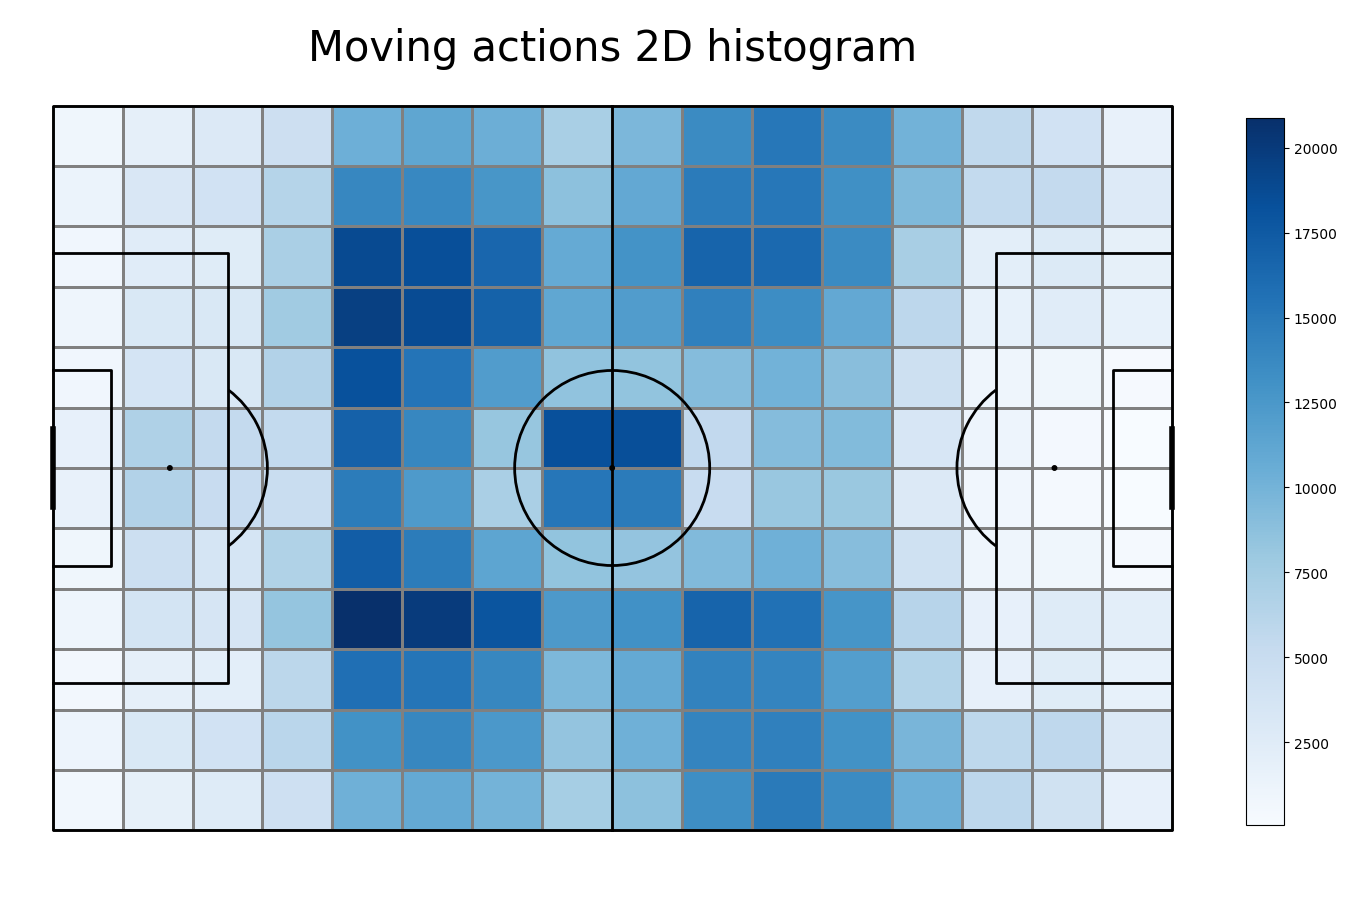

In [14]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]

df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#get move_df
move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
fail_count = 0
len_before = len(move_df)
move_df = move_df.drop(move_df[move_df.positions.apply(lambda cell: len(cell) < 2)].index) # drop rows with less than 2 positions
len_after = len(move_df)
print(f"Deleted {len_before - len_after} rows")
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
move_df = move_df.loc[(((move_df["end_x"] != 0) & (move_df["end_y"] != 68)) & ((move_df["end_x"] != 105) & (move_df["end_y"] != 0)))]

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

## Shots
To calculate the Expected Threat we also need shots. First we filter them
from the database. We also create new columns with the coordinates and plot their location.
We store the number of shot occurences in each bin in a 2D array as well.



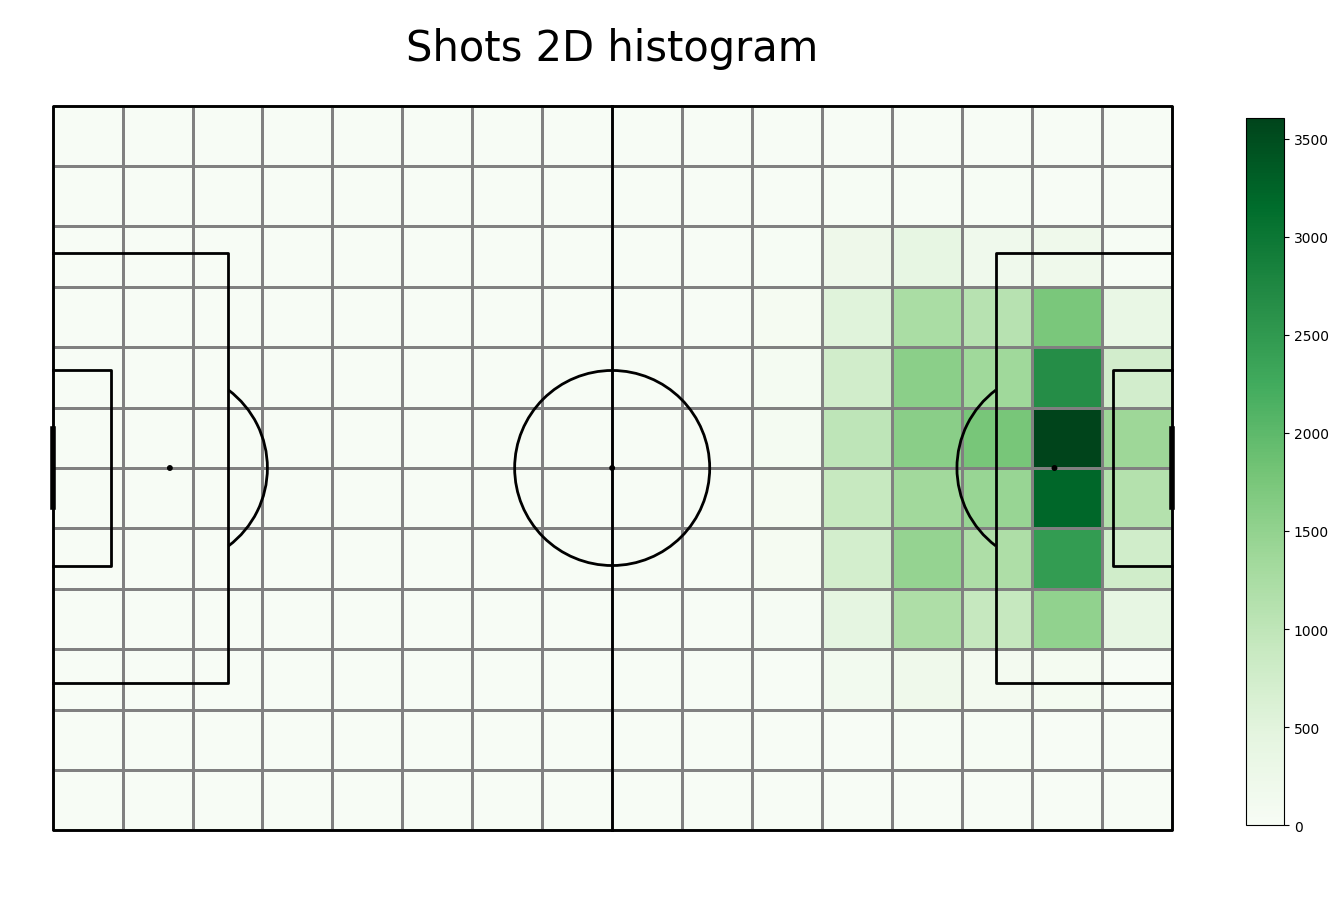

In [15]:
#get shot df
shot_df = df.loc[df['subEventName'] == "Shot"]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

## Goals
To calculate the Expected Threat we need also goals. We filter them 
from the shots dataframe. 
We store the number of goal occurences in each bin in 2D array as well.



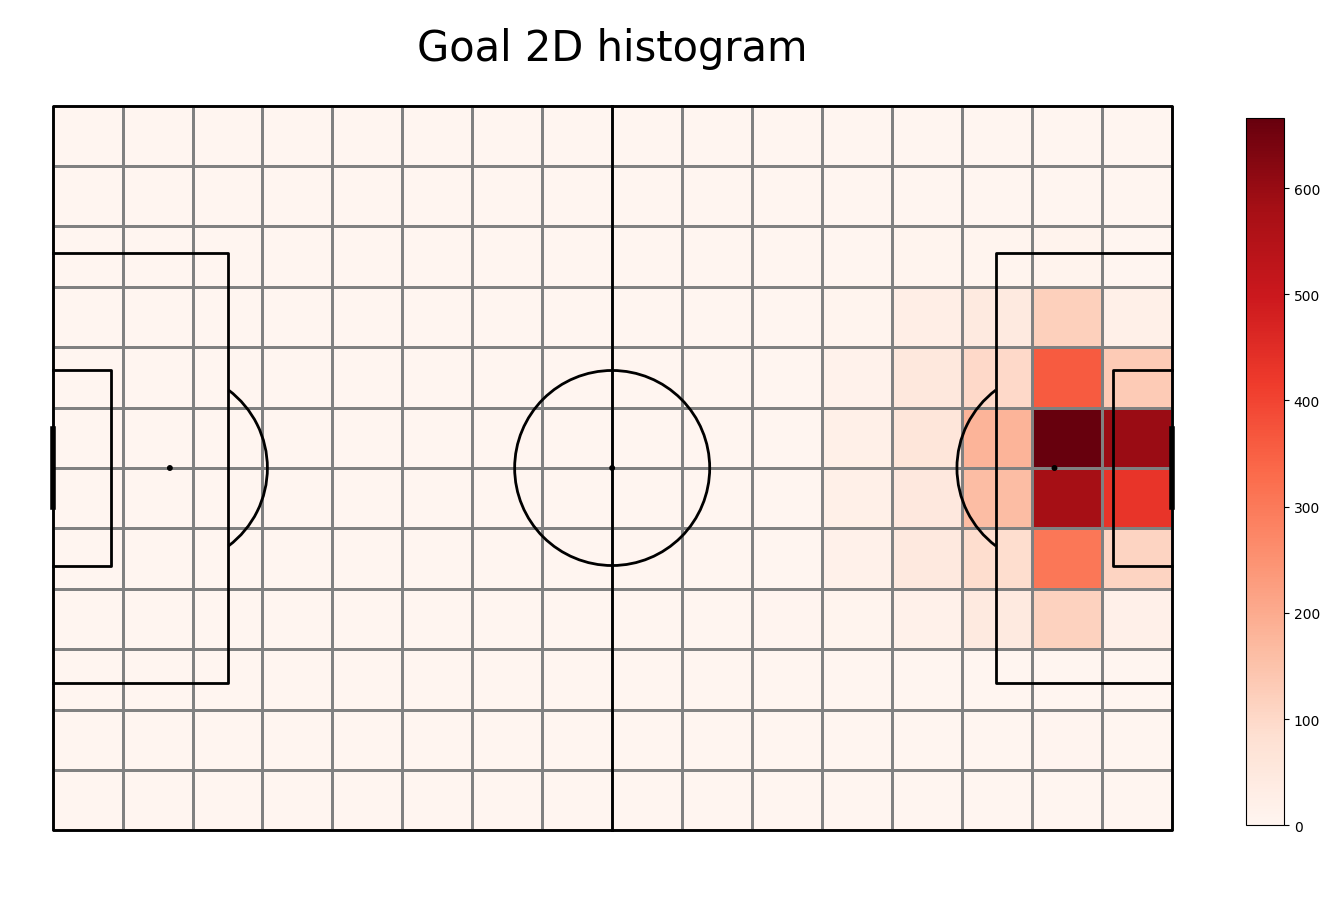

In [16]:
#get goal df
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in eval(x.tags), axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

## Move probability
We now need to calculate the probability of each moving action. To do so, we divide its number
in each bin by the sum of moving actions and shots in that bin. Then, we plot it. 



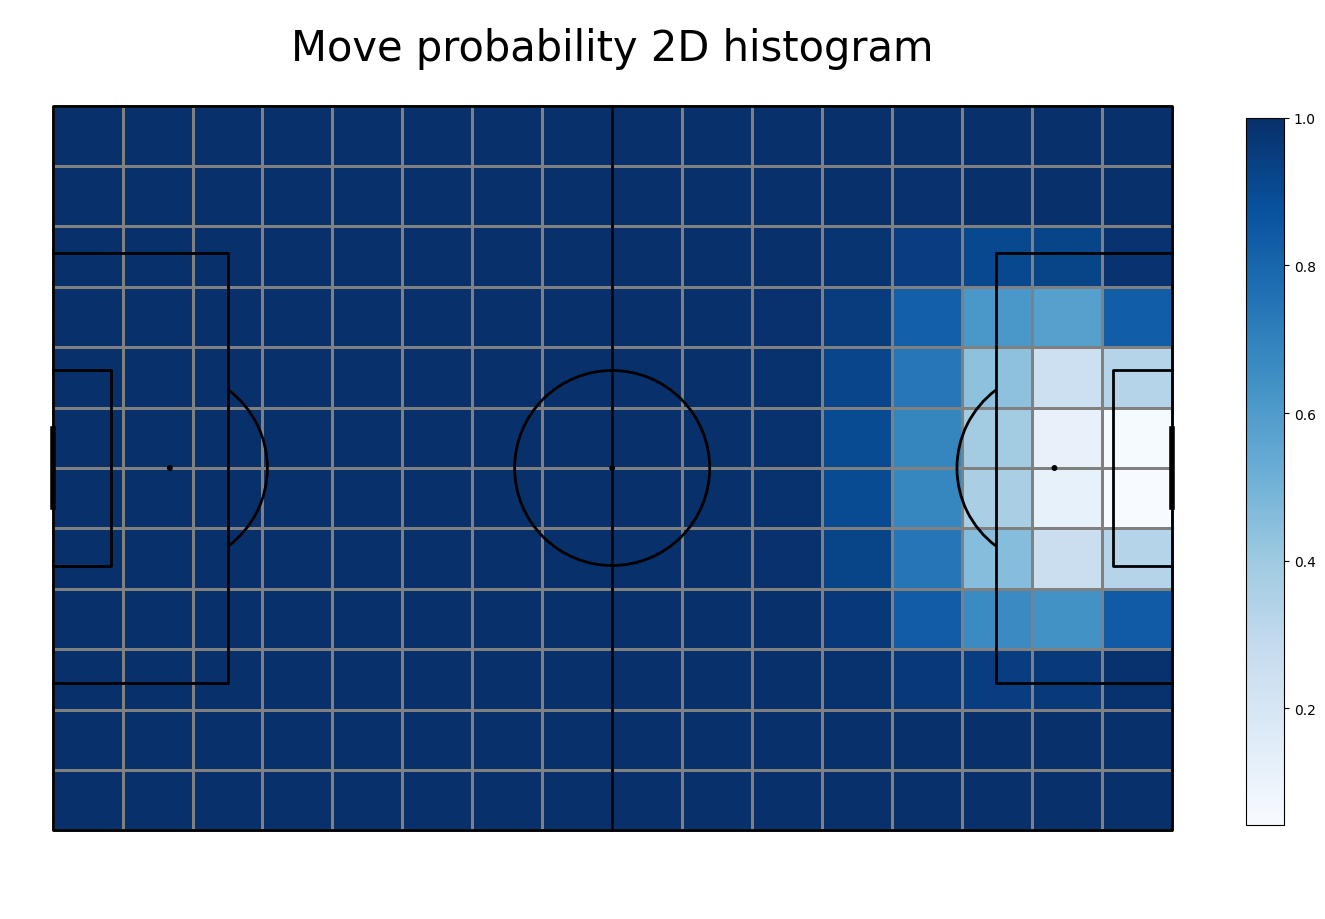

In [17]:
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

## Move probability
We also need to calculate the probability of a shot in each area. Again, we divide its number
in each bin by the sum of moving actions and shots in that bin. Then plot it.



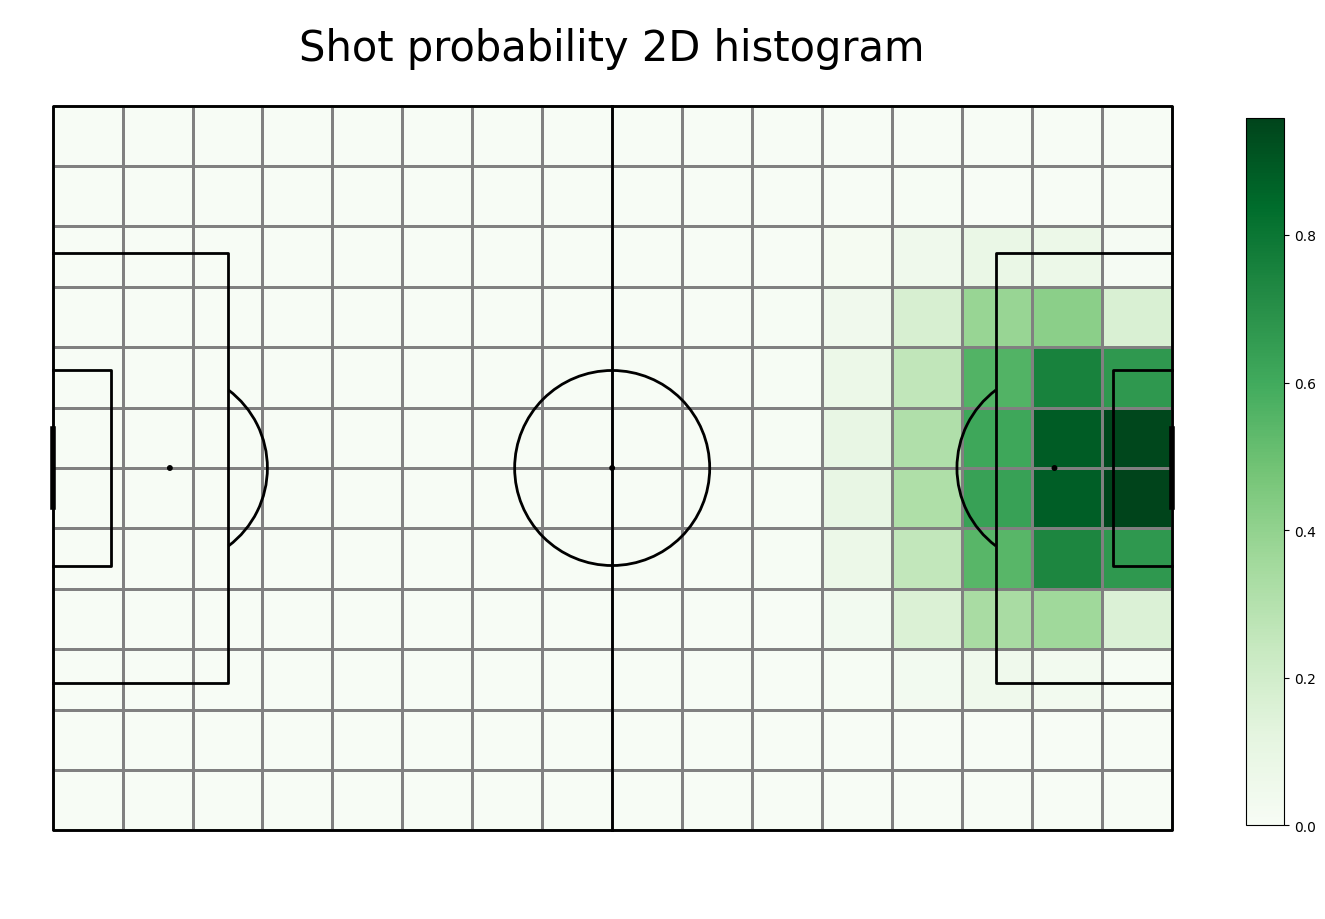

In [18]:
shot_probability = shot_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

## Goal probability
The next thing needed is the goal probability. It's calculated here in a
rather naive way - number of goals in this area divided by number of shots there.
This is a simplified expected goals model.



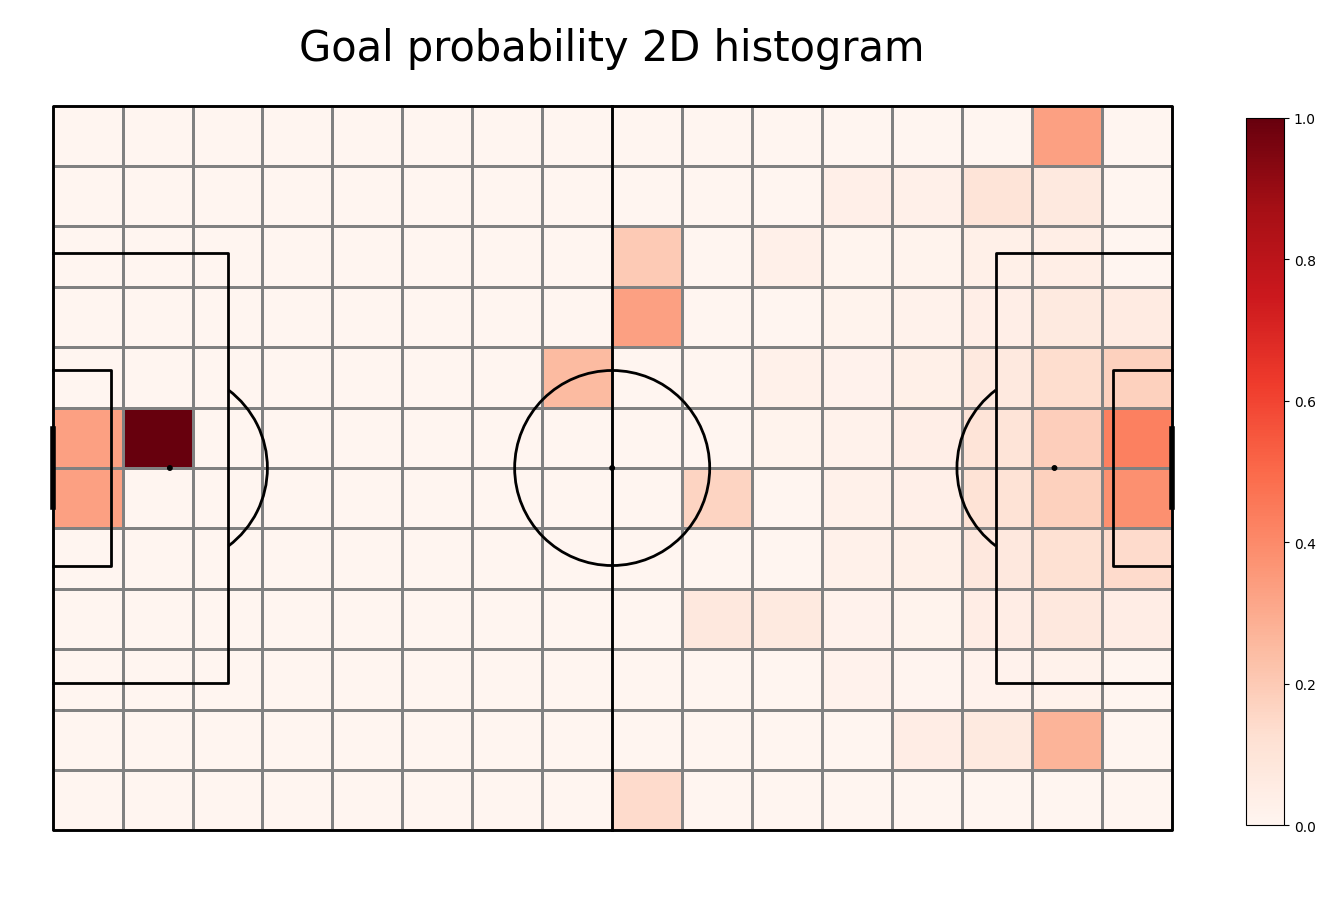

In [19]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

## Transition matirices
For each of 192 sectors we need to calculate a transition matrix - a matrix of probabilities
going from one zone to another one given that the ball was moved. First, we create
another columns in the *move_df*
with the bin on the histogram that the event started and ended in. Then, we group the data
by starting sector and count starts from each of them. As the next step, for each of the sectors
we calculate the probability of transfering the ball from it to all 192 sectors on the pitch. 
given that the ball was moved. We do it as the division of events that went to the end sector
by all events that started in the starting sector. As the last step, we vizualize the 
transition matrix for the sector in the bottom left corner of the pitch.



   eventId subEventName            tags  playerId  \
0        8  Simple pass  [{'id': 1801}]    122671   
1        8    High pass  [{'id': 1801}]    139393   
4        8  Simple pass  [{'id': 1801}]    122847   
5        8  Simple pass  [{'id': 1801}]    122832   
7        8  Simple pass  [{'id': 1801}]    122847   

                                  positions  matchId eventName  teamId  \
0  [{'y': 50, 'x': 50}, {'y': 53, 'x': 35}]  2057954      Pass   16521   
1  [{'y': 53, 'x': 35}, {'y': 19, 'x': 75}]  2057954      Pass   16521   
4  [{'y': 17, 'x': 63}, {'y': 15, 'x': 71}]  2057954      Pass   16521   
5  [{'y': 15, 'x': 71}, {'y': 11, 'x': 92}]  2057954      Pass   16521   
7  [{'y': 11, 'x': 88}, {'y': 13, 'x': 88}]  2057954      Pass   16521   

  matchPeriod   eventSec  subEventId         id              nextEvent  \
0          1H   1.656214        85.0  258612104              High pass   
1          1H   4.487814        83.0  258612106               Air duel   
4          1H 

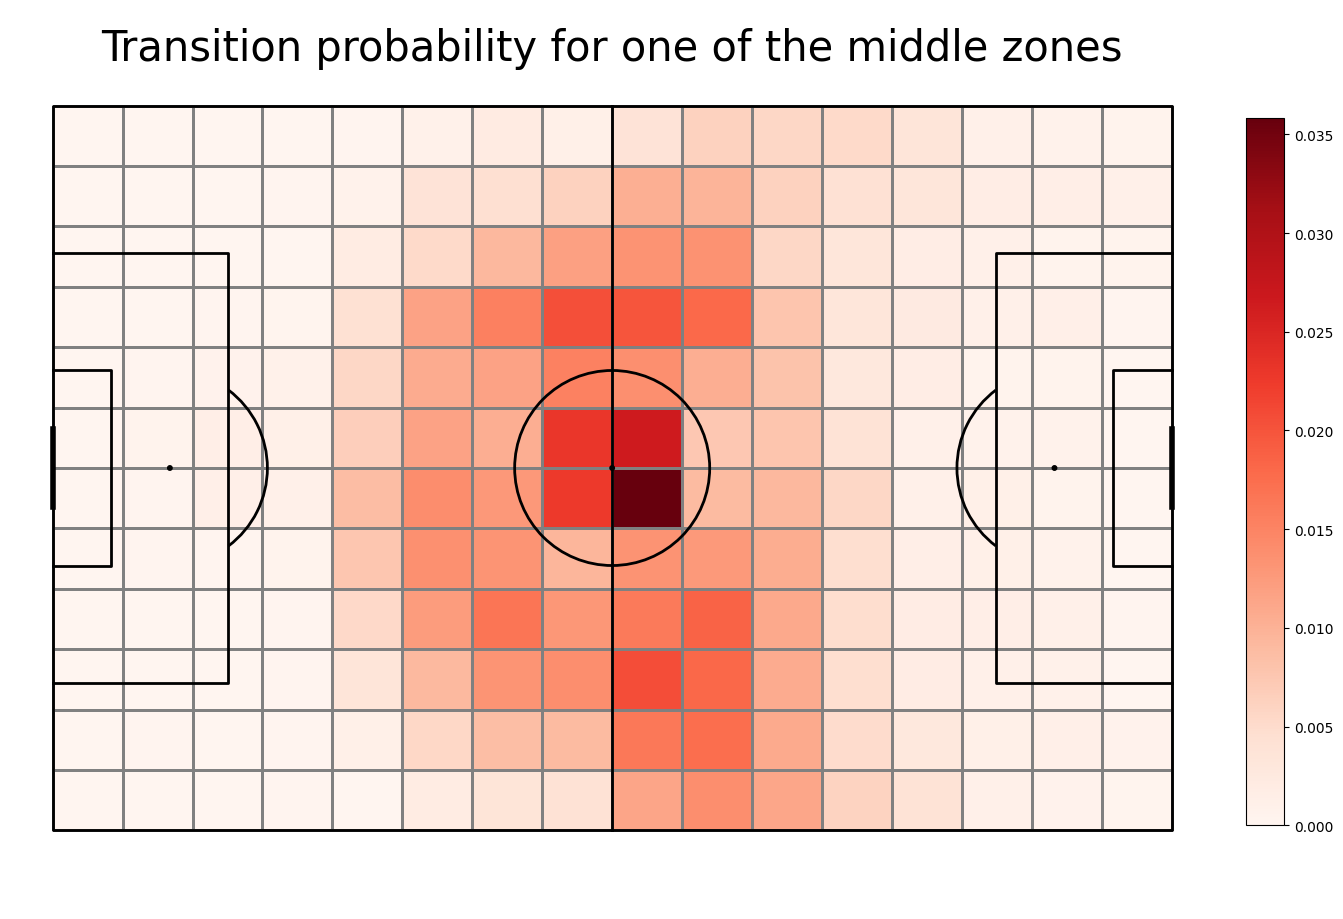

In [23]:
#move start index - using the same function as mplsoccer, it should work
rows_before = len(move_df)
print(move_df.head())
# Drop rows that are out of the field
move_df.drop(move_df[(move_df.x>105) | (move_df.x<0)].index, inplace = True)
move_df.drop(move_df[(move_df.y>68) | (move_df.y<0)].index, inplace = True)
move_df.drop(move_df[(move_df.end_x<0) |(move_df.end_x>105)].index, inplace = True)
move_df.drop(move_df[(move_df.end_y<0) | (move_df.end_y>68)].index, inplace = True)

print("Dropped", rows_before - len(move_df), "rows")
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y), 
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y), 
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

#df with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)
print(len(df_count_starts))

count_sectors = 0
transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_cound_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_cound_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    count_sectors += 1
    transition_matrices.append(T_matrix)
print(count_sectors)
#let's plot it for the zone [1,1] - left down corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
goal["statistic"] = transition_matrices[90]
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

## Calculating Expected Threat matrix
We are now ready to calculate the Expected Threat. We do it by first calculating
(probability of a shot)*(probability of a goal given a shot). This gives the probability of a
goal being scored right away. This is the shoot_expected_payoff. We then add this to
the move_expected_payoff, which is what the payoff (probability of a goal) will be
if the player passes the ball. It is this which is the xT

By iterating this process 6 times, the xT gradually converges to its final value.



(192, 12, 16)
[[[0.0690571  0.07569721 0.06374502 ... 0.         0.00132802 0.        ]
  [0.06772908 0.062417   0.03320053 ... 0.         0.         0.        ]
  [0.03718459 0.01992032 0.00398406 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.03299492 0.05499154 0.06260575 ... 0.00084602 0.         0.        ]
  [0.03722504 0.06091371 0.02453469 ... 0.         0.         0.        ]
  [0.02622673 0.02622673 0.01269036 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.01519757 0.05775076 0.05319149 ... 0.         0.         0.        ]
  [0.027

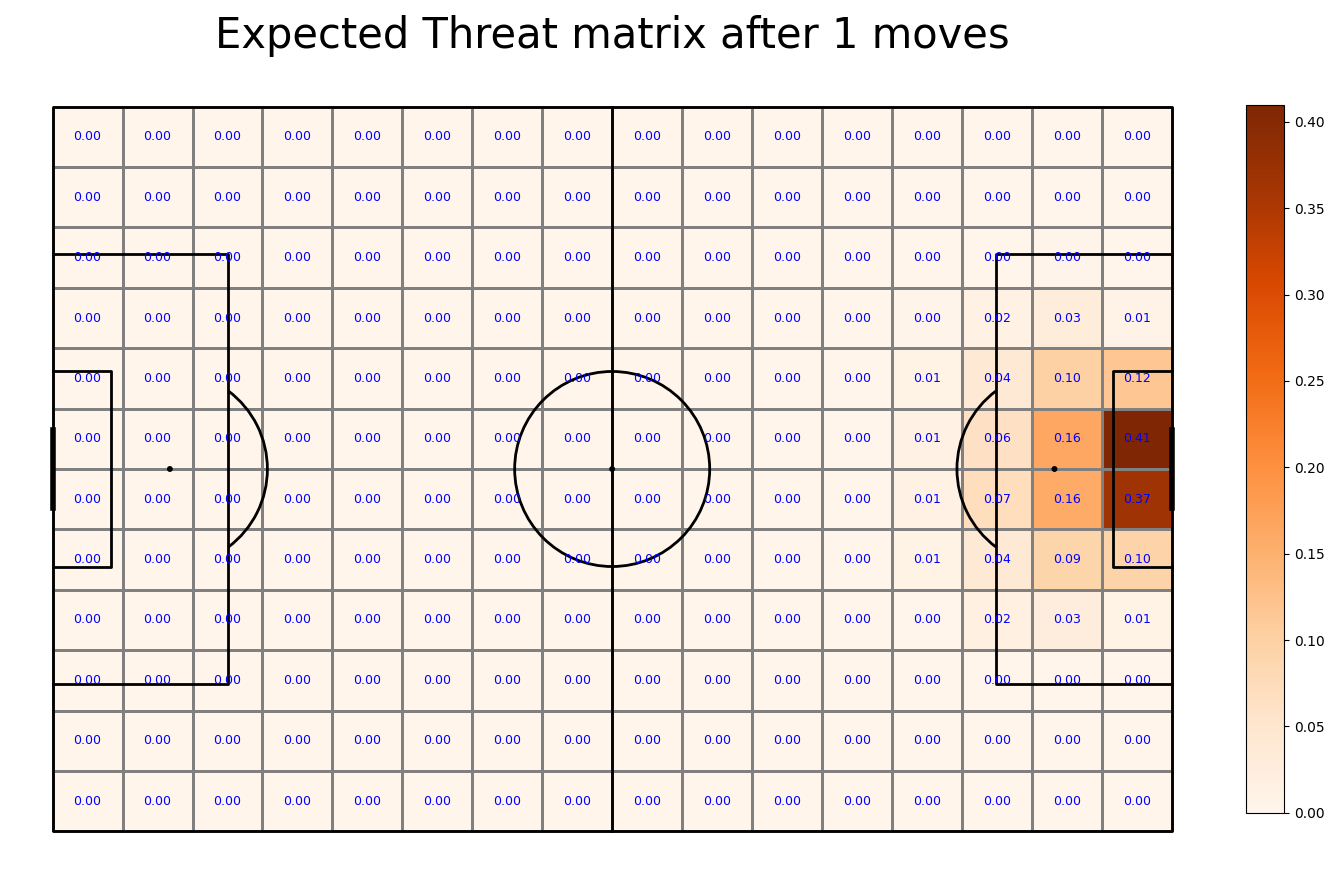

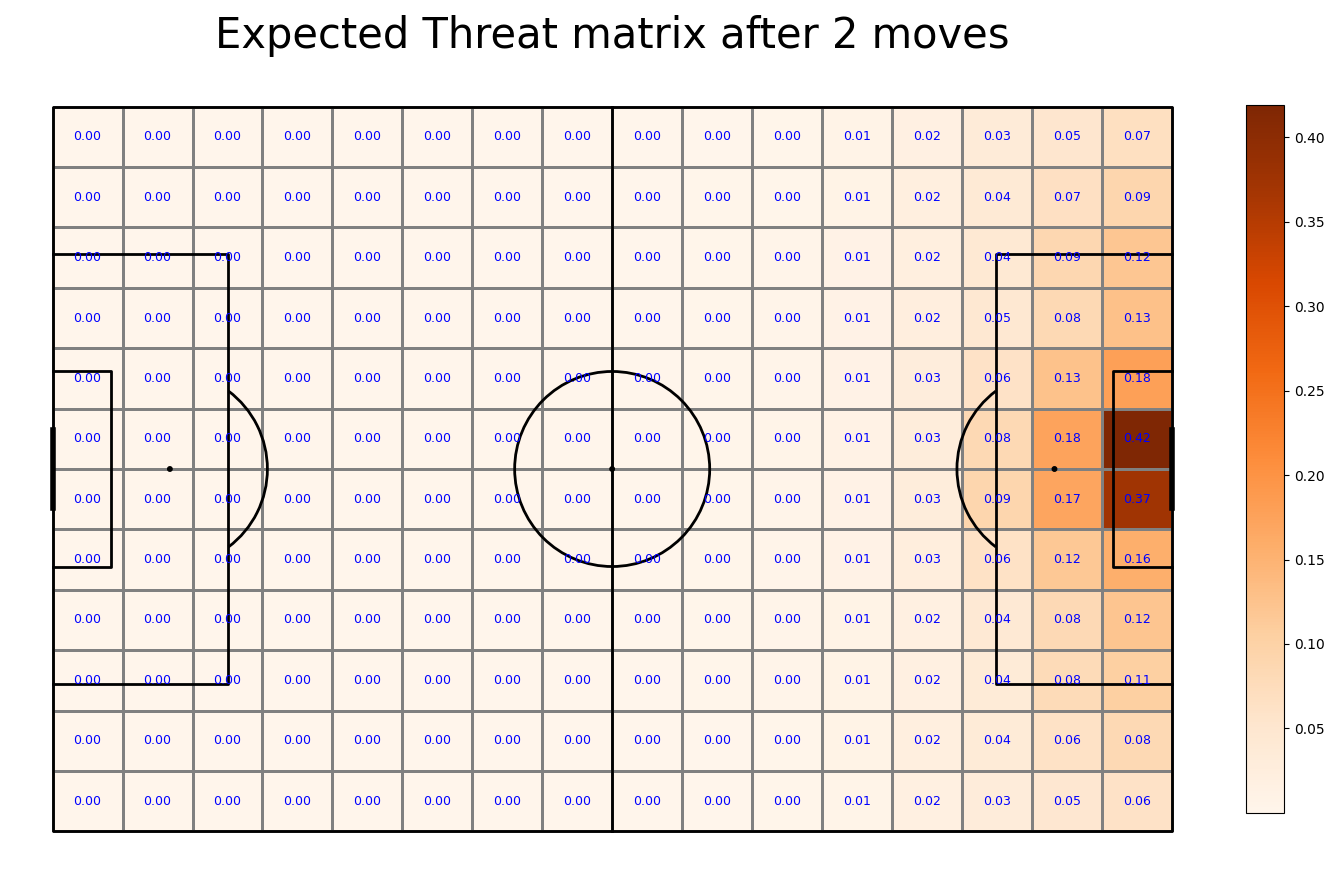

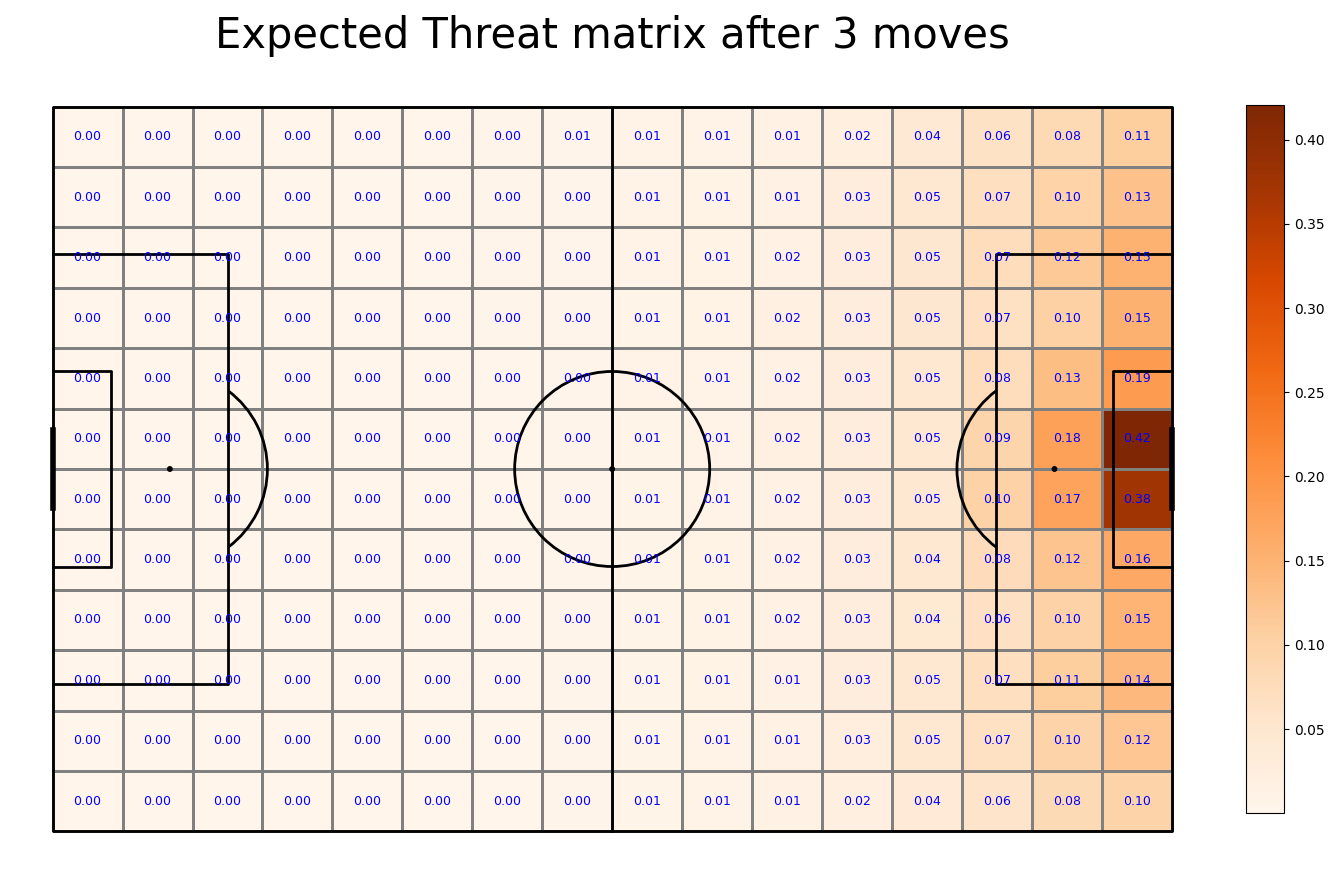

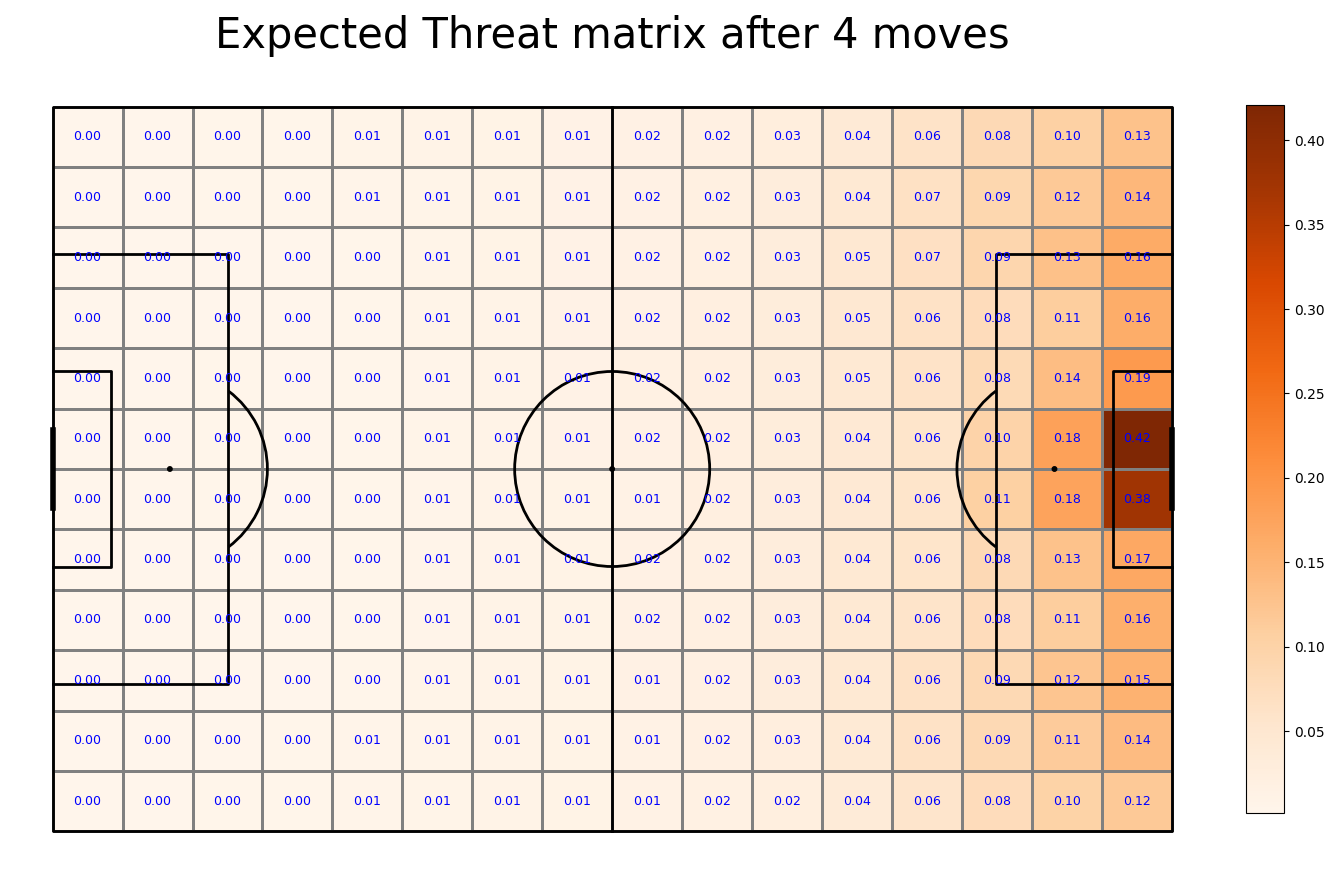

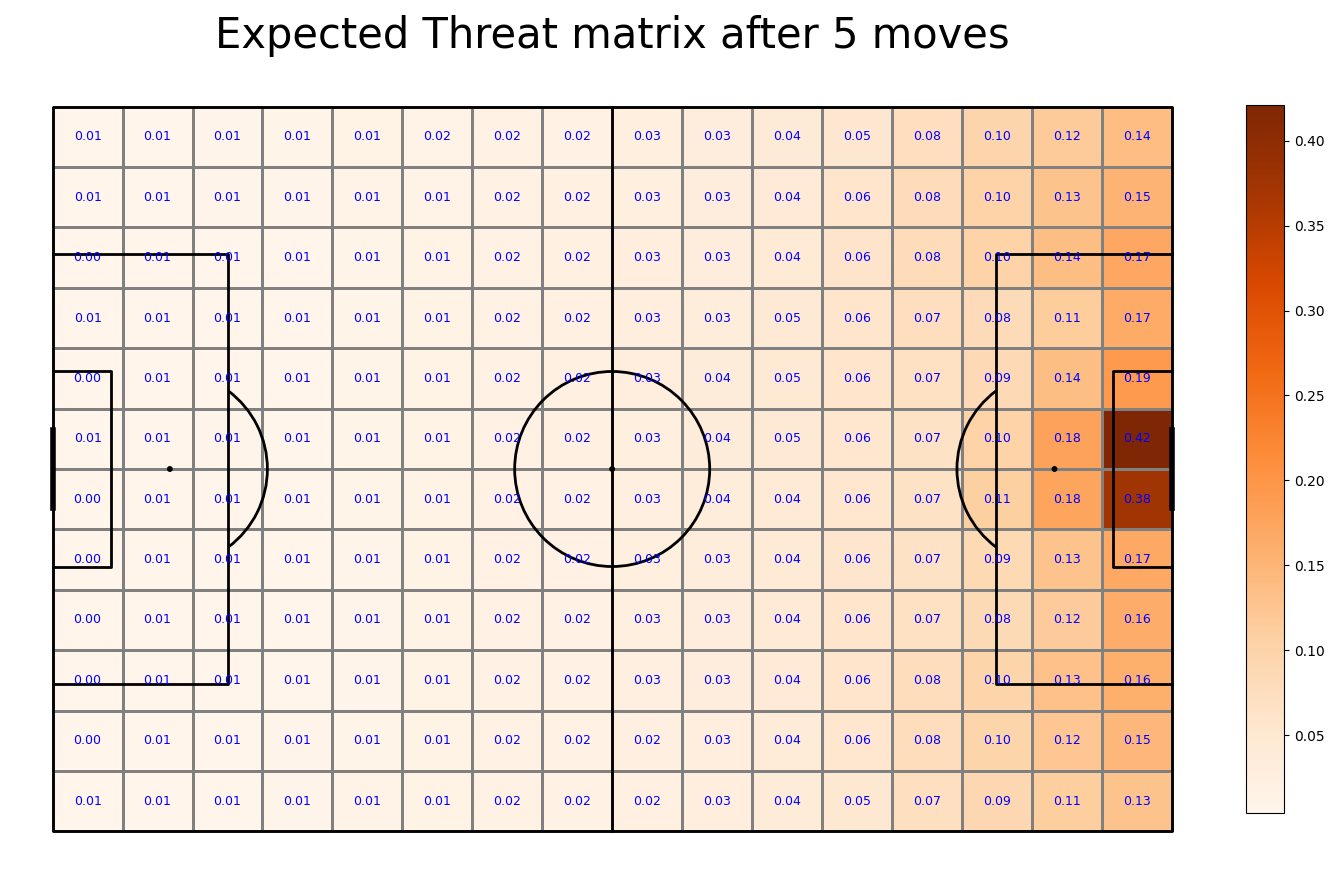

In [24]:
transition_matrices_array = np.array(transition_matrices)
print(transition_matrices_array.shape)
print(transition_matrices_array)

xT = np.zeros((12, 16))

for i in range(5):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff                                         

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.01, title_space=0, endnote_space=0)
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

## Applying xT value to moving actions
As the next step we calculate for progressive and successful events the xT added.
From the matrix we get the xT value for starting and ending zone and subtract the first one
from the latter one. This is one way of doing that. The other would be to keep all moving the ball actions,
calculate xT for the successful ones and assign -xT value of the starting zone for the unsuccessful ones. 



In [ ]:
#only successful
successful_moves = move_df.loc[move_df.apply(lambda x:{'id':1801} in x.tags, axis = 1)]
#calculatexT
successful_moves["xT_added"] = successful_moves.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] 
                                                      - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)
#only progressive
value_adding_actions = successful_moves.loc[successful_moves["xT_added"] > 0]

## Finding out players with highest xT
As the last step we want to find out which players who played more than 400 minutes
scored the best in possesion-adjusted xT per 90. We repeat steps that you already know 
from [Radar Plots](https://soccermatics.readthedocs.io/en/latest/gallery/lesson3/plot_RadarPlot.html).
We group them by player, sum, assign merge it with players database to keep players name,
adjust team possesion and per 90. Only the last step differs, since we stored *percentage_df*
in a .json file that can be found [here](https://github.com/soccermatics/Soccermatics/tree/main/course/lessons/minutes_played).



In [ ]:
#group by player
xT_by_player = value_adding_actions.groupby(["playerId"])["xT_added"].sum().reset_index()

#merging player name
path = os.path.join(str(pathlib.Path().resolve().parents[0]),"data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]

summary = xT_by_player.merge(to_merge, how = "left", on = ["playerId"])

path = os.path.join(str(pathlib.Path().resolve().parents[0]),"minutes_played", 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
#filtering over 400 per game
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
#calculating per 90
summary["xT_per_90"] = summary["xT_added"]*90/summary["minutesPlayed"]

#adjusting for possesion
path = os.path.join(str(pathlib.Path().resolve().parents[0]),"minutes_played", 'player_possesion_England.json')
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])

summary["xT_adjusted_per_90"] = (summary["xT_added"]/summary["possesion"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(5)

## Challenge
1. Write the Calculating Expected Threat matrix section using for loops to get a better understanding of the algorithm!
2. Don't remove unsuccessful and non-progressive actions. Assign -xT for unsuccessful ones!

